### Dataset preparation

In [1]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from neuralsens import partial_derivatives as ns

# others
from mltools import classification_tools as CT
from mltools import model_tools as MT

In [7]:
df = pd.read_csv('fico.csv')
# Pasar la variable RiskPerformance a int64
df['RiskPerformance'] = df['RiskPerformance'].astype('int64')
# Put the column RiskPerformance as a category
df['RiskPerformance'] = df['RiskPerformance'].astype('category')
# Change RiskPerformance values, if they are 1 to True and if they are 0 to False
df['RiskPerformance'] = df['RiskPerformance'].replace({1: 'Yes', 0: 'No'})
df.dropna(inplace=True)

In [8]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'MSinceOldestTradeOpen', 'PercentTradesWBalance', 'NumTotalTrades', 
       'PercentInstallTrades', 'NumSatisfactoryTrades', 'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
OUTPUT = 'RiskPerformance'

X = df[INPUTS]
Y = df[OUTPUT]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2023, #seed for replication
                                                    stratify = Y)   #Preserves distribution of y. Same proportion. useful for classification but not for regression problemas

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity

### Training of MLP model

In [9]:
#-------------------------------------------------------------------------------------------------
#------------------------------- MLP Class MODEL -------------------------------------------------
#-------------------------------------------------------------------------------------------------
INPUTS_MLP = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden', 'AverageMInFile', 'PercentTradesWBalance', 'PercentInstallTrades', 'NumTotalTrades', 'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
# Configure model and hyparameter tuning
param = {'MLP__alpha': [1e-15, 1e-13, 1e-11, 1e-9], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(20,),(25,)], # Number of neurons in each hidden layer, enters as tuples
         'MLP__learning_rate_init': [0.0001, 0.001, 0.01]} # Learning rate parameter for 'adam' algorithm

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='adam', # Update function
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=2023,
                                             verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy metric to use
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], Y_train) # Search in grid

Iteration 1, loss = 0.71709343
Iteration 2, loss = 0.69289229
Iteration 3, loss = 0.67449460
Iteration 4, loss = 0.66108884
Iteration 5, loss = 0.65042684
Iteration 6, loss = 0.64096652
Iteration 7, loss = 0.63235194
Iteration 8, loss = 0.62423978
Iteration 9, loss = 0.61667022
Iteration 10, loss = 0.60936477
Iteration 11, loss = 0.60265787
Iteration 12, loss = 0.59633886
Iteration 13, loss = 0.59065086
Iteration 14, loss = 0.58542439
Iteration 15, loss = 0.58081180
Iteration 16, loss = 0.57667059
Iteration 17, loss = 0.57308861
Iteration 18, loss = 0.56994052
Iteration 19, loss = 0.56719915
Iteration 20, loss = 0.56481645
Iteration 21, loss = 0.56280279
Iteration 22, loss = 0.56113663
Iteration 23, loss = 0.55955588
Iteration 24, loss = 0.55820341
Iteration 25, loss = 0.55721118
Iteration 26, loss = 0.55620215
Iteration 27, loss = 0.55548910
Iteration 28, loss = 0.55488326
Iteration 29, loss = 0.55422823
Iteration 30, loss = 0.55377993
Iteration 31, loss = 0.55333606
Iteration 32, los

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('MLP',
                                        MLPClassifier(activation='logistic',
                                                      max_iter=450,
                                                      random_state=2023,
                                                      verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [1e-15, 1e-13, 1e-11, 1e-09],
                         'MLP__hidden_layer_sizes': [(5,), (10,), (15,), (20,),
                                                     (25,)],
                         'MLP__learning_rate_init': [0.0001, 0.001, 0.01]},
             scoring='accuracy')

ValueError: Index contains duplicate entries, cannot reshape

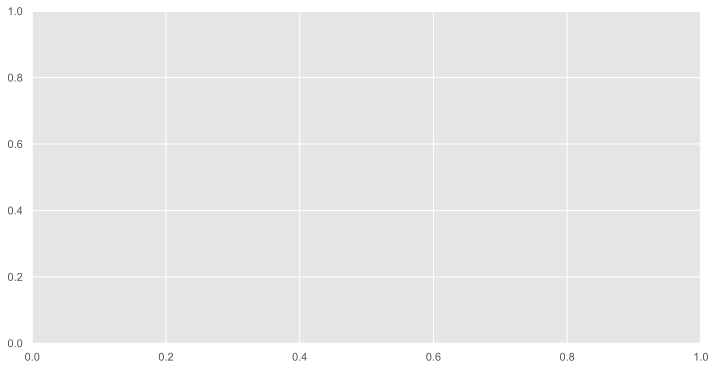

In [11]:
MT.plotModelGridError(MLP_fit, xscale2="log")

In [26]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(MLP_fit, X_train[INPUTS_MLP], Y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


KeyboardInterrupt: 

In [12]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(Y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [13]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)

In [14]:
sensmlp.summary()

Sensitivity analysis of [8, 15, 1] MLP network.

Sensitivity measures of each output:

$ExternalRiskEstimate 

                                  mean       std  mean_squared
ExternalRiskEstimate         -0.097273  0.045392      0.107343
NetFractionRevolvingBurden    0.055441  0.025758      0.061132
AverageMInFile               -0.055876  0.026038      0.061645
PercentTradesWBalance         0.023503  0.011444      0.026141
PercentInstallTrades          0.012033  0.005592      0.013269
NumTotalTrades               -0.030007  0.013817      0.033035
PercentTradesNeverDelq       -0.064731  0.030605      0.071601
MSinceMostRecentInqexcl7days -0.068830  0.032443      0.076093


In [15]:
sensmlp.info()

Sensitivity analysis of [8, 15, 1] MLP network.

3182 samples

Sensitivities of each output (only 5 first samples):

$ExternalRiskEstimate 

   ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
0             -0.110395                    0.063222       -0.065220   
1             -0.105654                    0.062991       -0.061861   
2             -0.149375                    0.084863       -0.083759   
3             -0.084030                    0.049016       -0.045796   
4             -0.064457                    0.037985       -0.035653   

   PercentTradesWBalance  PercentInstallTrades  NumTotalTrades  \
0               0.024012              0.014527       -0.035620   
1               0.022971              0.012666       -0.029291   
2               0.036906              0.019760       -0.045941   
3               0.020368              0.012491       -0.026523   
4               0.013545              0.005229       -0.016446   

   PercentTradesNeverDelq  MSinceMo

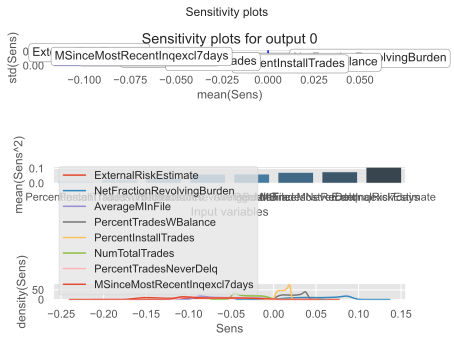

In [16]:
sensmlp.plot()
## Make this plot bigger, because I cannot see anything


In [19]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,1]

#visualize evaluated data
dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,MSinceOldestTradeOpen,PercentTradesWBalance,PercentInstallTrades,NumSatisfactoryTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_MLP_pred,Y_MLP_prob_neg,Y_MLP_prob_pos
1605,83.0,0.0,50.0,157.0,20.0,53.0,13.0,93.0,3.0,No,No,0.748003,0.251997
524,81.0,34.0,75.0,183.0,40.0,44.0,45.0,100.0,0.0,No,No,0.760106,0.239894
2994,68.0,25.0,34.0,81.0,65.0,32.0,25.0,100.0,2.0,No,Yes,0.499204,0.500796
103,60.0,35.0,25.0,49.0,72.0,32.0,24.0,100.0,0.0,Yes,Yes,0.192653,0.807347
4112,59.0,78.0,52.0,147.0,100.0,71.0,5.0,86.0,12.0,Yes,Yes,0.187654,0.812346


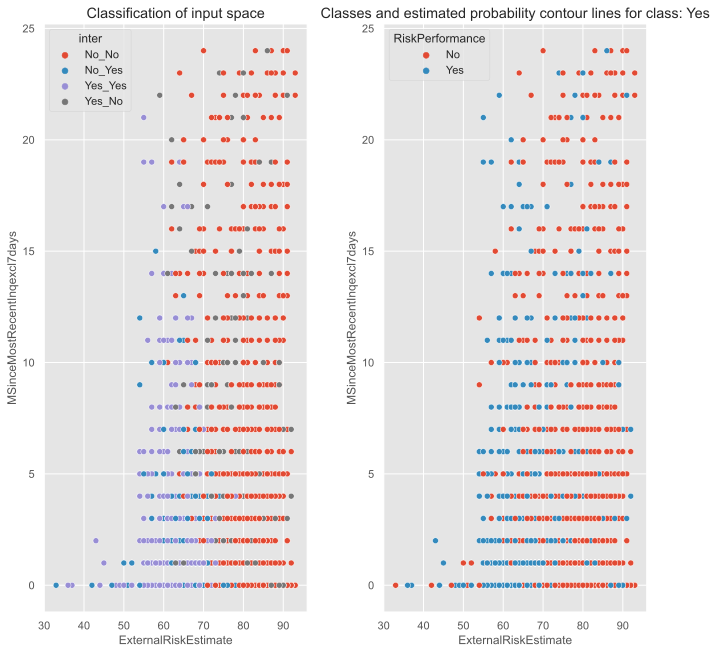

In [17]:
### Plot classification in a 2 dimensional space
plt.figure(figsize=(10, 10))
CT.plot2DClass(X_train[INPUTS_MLP], dfTR_eval['RiskPerformance'], MLP_fit, 'ExternalRiskEstimate', 'MSinceMostRecentInqexcl7days', 'Yes', 50) 

In [21]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_MLP_pred'], labels=['No','Yes'])

KeyError: 'Y_MLP_pred'

In [24]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_MLP_pred'], labels=['No','Yes'])

KeyError: 'Y_MLP_pred'

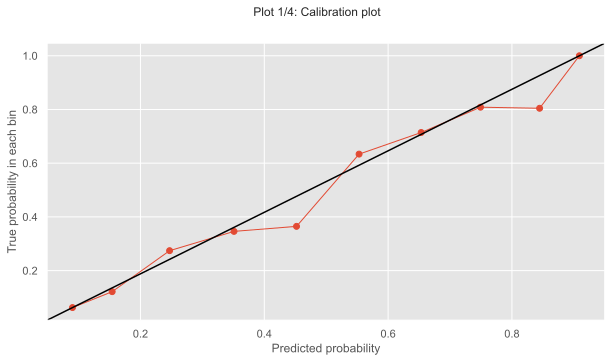

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


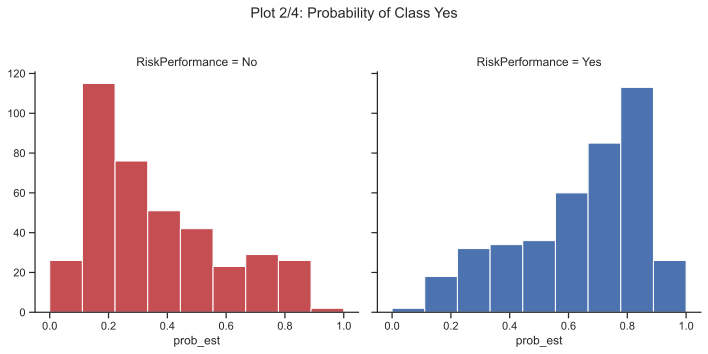

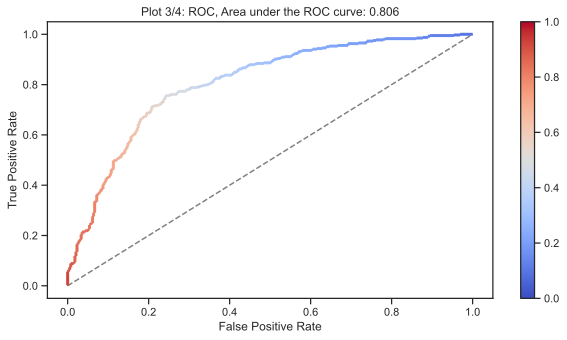

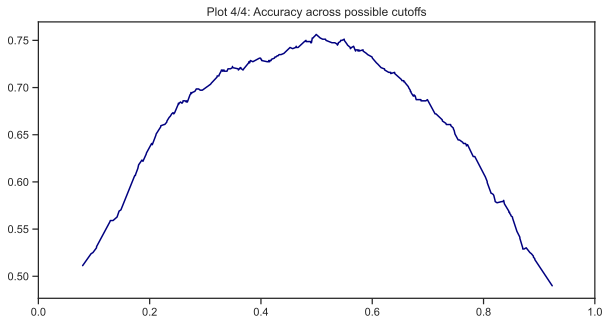

In [22]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass='Yes')